# T008 · Protein data acquisition: Protein Data Bank (PDB) 

Authors:

- Anja Georgi, CADD seminar, 2017, Charité/FU Berlin
- Majid Vafadar, CADD seminar, 2018, Charité/FU Berlin
- Jaime Rodríguez-Guerra, Volkamer lab, Charité
- Dominique Sydow, Volkamer lab, Charité

__Talktorial T008__: This talktorial is part of the TeachOpenCADD pipeline described in the first TeachOpenCADD publication ([_J. Cheminform._ (2019), **11**, 1-7](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x)), comprising of talktorials T001-T010.

## Aim of this talktorial

In this talktorial, we conduct the groundwork for the next talktorial where we will generate a ligand-based ensemble pharmacophore for EGFR. Therefore, we 
(i) fetch all PDB IDs for EGFR from the PDB database, 
(ii) retrieve five protein-ligand structures, which have the best structural quality and are derived from X-ray crystallography, and 
(iii) align all structures to each in 3D as well as extract and save the ligands to be used in the next talktorial.

### Contents in Theory

* Protein Data Bank (PDB)
* Python package `pypdb`

### Contents in Practical

* Select query protein
* Get all PDB IDs for query protein
* Get statistic on PDB entries for query protein
* Get meta information on PDB entries
* Filter and sort meta information on PDB entries
* Get meta information of ligands from top structures
* Draw top ligand molecules
* Create protein-ligand ID pairs
* Get the PDB structure files
* Align PDB structures

### References

* Protein Data Bank 
([PDB website](http://www.rcsb.org/))
* `pypdb` python package 
([_Bioinformatics_ (2016), **1**, 159-60](https://academic.oup.com/bioinformatics/article-lookup/doi/10.1093/bioinformatics/btv543), [documentation](http://www.wgilpin.com/pypdb_docs/html/))
* Molecular superposition with the python package `opencadd` ([repository](https://github.com/volkamerlab/opencadd))

## Theory

### Protein Data Bank (PDB)

The Protein Data Bank (PDB) is one of the most comprehensive structural biology information database and a key resource in areas of structural biology, such as structural genomics and drug design ([PDB website](http://www.rcsb.org/)).

Structural data is generated from structural determination methods such as X-ray crystallography (most common method), nuclear magnetic resonance (NMR), and cryo electron microscopy (cryo-EM). 
For each entry, the database contains (i) the 3D coordinates of the atoms and the bonds connecting these atoms for proteins, ligand, cofactors, water molecules, and ions, as well as (ii) meta information on the structural data such as the PDB ID, the authors, the deposition date, the structural determination method used and the structural resolution.

The structural resolution is a measure of the quality of the data that has been collected and has the unit Å (Angstrom). The lower the value, the higher the quality of the structure. 

The PDB website offers a 3D visualization of the protein structures (with ligand interactions if available) and a structure quality metrics, as can be seen for the PDB entry of an example epidermal growth factor receptor (EGFR) with the PDB ID [3UG5](https://www.rcsb.org/structure/3UG5).

![protein ligand complex](images/protein-ligand-complex.png)

Figure 1: The protein structure (in gray) with an interacting ligand (in green) is shown for an example epidermal growth factor receptor (EGFR) with the PDB ID 3UG5 (figure by Dominique Sydow).

### Python package `pypdb`

`pypdb` is a python programming interface for the PDB and works exclusively in Python 3 ([_Bioinformatics_ (2016), **1**, 159-60](https://academic.oup.com/bioinformatics/article-lookup/doi/10.1093/bioinformatics/btv543), [documentation](http://www.wgilpin.com/pypdb_docs/html/)). 
This package facilitates the integration of automatic PDB searches within bioinformatics workflows and simplifies the process of performing multiple searches based on the results of existing searches. 
It also allows an advanced querying of information on PDB entries. 
The PDB currently uses a RESTful API that allows for the retrieval of information via standard HTML vocabulary. `pypdb` converts these objects into XML strings. 

Check out the [demo](https://github.com/williamgilpin/pypdb/blob/master/demos/demos.ipynb) notebook introducing the `pypdb` API.

## Practical

In [1]:
import collections
import logging
import pathlib
import time
import warnings

import pandas as pd
from tqdm.auto import tqdm
import redo
import requests_cache
import nglview
import pypdb
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

from opencadd.structure.superposition.api import align, METHODS
from opencadd.structure.core import Structure

# Disable some unneeded warnings
logger = logging.getLogger("opencadd")
logger.setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

# cache requests -- this will speed up repeated queries to PDB
requests_cache.install_cache("rcsb_pdb", backend="memory")

In [2]:
# define paths
HERE = pathlib.Path(_dh[-1])
DATA = HERE / "data"

### Select query protein

We use EGFR as query protein for this talktorial. The UniProt ID of EGFR is `P00533`, which will be used in the following to query the PDB database.

### Get all PDB IDs for query protein

First, we get all PDB structures for our query protein EGFR, using the `pypdb` search function `Query(search_term).search()`.

In [3]:
found_pdb_ids = pypdb.Query("P00533").search()

print("Sample PDB IDs found for query:", *found_pdb_ids[:3], "...")
print("Number of EGFR structures found:", len(found_pdb_ids))

Sample PDB IDs found for query: 2M0B 2M20 1Z9I ...
Number of EGFR structures found: 221


### Get meta information for PDB entries

We use `describe_pdb` to get meta information about the structures, which is stored per structure as a dictionary.

Note: we only fetch meta information on PDB structures here, we do not fetch the structures (3D coordinates), yet.

> The `redo.retriable` line is a _decorator_. This wraps the function and provides extra functionality. In this case, it will retry failed queries automatically (10 times maximum).

In [4]:
@redo.retriable(attempts=10, sleeptime=2)
def describe_one_pdb_id(pdb_id):
    """Fetch meta information from PDB."""
    described = pypdb.describe_pdb(pdb_id)
    if described is None:
        print(f"! Error while fetching {pdb_id}, retrying ...")
        raise ValueError(f"Could not fetch PDB id {pdb_id}")
    return described

In [5]:
pdbs_data = [describe_one_pdb_id(pdb_id) for pdb_id in found_pdb_ids]
pdbs_data[0]

{'audit_author': [{'name': 'Lesovoy, D.M.', 'pdbx_ordinal': 1},
  {'name': 'Bocharov, E.V.', 'pdbx_ordinal': 2},
  {'name': 'Pustovalova, Y.E.', 'pdbx_ordinal': 3},
  {'name': 'Bocharova, O.V.', 'pdbx_ordinal': 4},
  {'name': 'Arseniev, A.S.', 'pdbx_ordinal': 5}],
 'citation': [{'country': 'NE',
   'id': 'primary',
   'journal_abbrev': 'Biochim. Biophys. Acta',
   'journal_id_astm': 'BBACAQ',
   'journal_id_csd': '0113',
   'journal_id_issn': '0006-3002',
   'journal_volume': '1858',
   'page_first': '1254',
   'page_last': '1261',
   'pdbx_database_id_doi': '10.1016/j.bbamem.2016.02.023',
   'pdbx_database_id_pub_med': 26903218,
   'rcsb_authors': ['Bocharov, E.V.',
    'Lesovoy, D.M.',
    'Pavlov, K.V.',
    'Pustovalova, Y.E.',
    'Bocharova, O.V.',
    'Arseniev, A.S.'],
   'rcsb_is_primary': 'Y',
   'rcsb_journal_abbrev': 'Biochim Biophys Acta',
   'title': 'Alternative packing of EGFR transmembrane domain suggests that protein-lipid interactions underlie signal conduction acros

Since we want to use the information to filter for relevant PDB structures, we convert the data set from dictionary to DataFrame for easier handling.

In [6]:
pdbs_data = pd.DataFrame(pdbs_data)
pdbs_data.head()

,audit_author,citation,entry,exptl,pdbx_audit_revision_category,pdbx_audit_revision_details,pdbx_audit_revision_group,pdbx_audit_revision_history,pdbx_audit_revision_item,pdbx_database_related,...,refine_hist,refine_ls_restr,reflns,software,symmetry,pdbx_sgproject,refine_analyze,reflns_shell,rcsb_binding_affinity,pdbx_audit_support
0,"[{'name': 'Lesovoy, D.M.', 'pdbx_ordinal': 1},...","[{'country': 'NE', 'id': 'primary', 'journal_a...",{'id': '2M0B'},[{'method': 'SOLUTION NMR'}],"[{'category': 'citation', 'data_content_type':...","[{'data_content_type': 'Structure model', 'ord...","[{'data_content_type': 'Structure model', 'gro...","[{'data_content_type': 'Structure model', 'maj...","[{'data_content_type': 'Structure model', 'ite...","[{'content_type': 'unspecified', 'db_id': '188...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'name': 'Endres, N.F.', 'pdbx_ordinal': 1}, ...","[{'country': 'US', 'id': 'primary', 'journal_a...",{'id': '2M20'},[{'method': 'SOLUTION NMR'}],NaN,"[{'data_content_type': 'Structure model', 'ord...",NaN,"[{'data_content_type': 'Structure model', 'maj...",NaN,"[{'content_type': 'unspecified', 'db_id': '188...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'name': 'Choowongkomon, K.', 'pdbx_ordinal':...","[{'country': 'US', 'id': 'primary', 'journal_a...",{'id': '1Z9I'},[{'method': 'SOLUTION NMR'}],NaN,"[{'data_content_type': 'Structure model', 'ord...","[{'data_content_type': 'Structure model', 'gro...","[{'data_content_type': 'Structure model', 'maj...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[{'name': 'Cai, Z.', 'pdbx_ordinal': 1}, {'nam...","[{'country': 'US', 'id': 'primary', 'journal_a...",{'id': '4TKS'},"[{'crystals_number': 1, 'method': 'X-RAY DIFFR...",NaN,"[{'data_content_type': 'Structure model', 'ord...","[{'data_content_type': 'Structure model', 'gro...","[{'data_content_type': 'Structure model', 'maj...",NaN,NaN,...,"[{'cycle_id': 'LAST', 'number_atoms_solvent': ...","[{'dev_ideal': 0.002, 'number': 2512, 'pdbx_re...","[{'number_obs': 8731, 'pdbx_diffrn_id': ['1'],...","[{'classification': 'refinement', 'name': 'PHE...","{'int_tables_number': 197, 'space_group_name_h...",NaN,NaN,NaN,NaN,NaN
4,"[{'name': 'Mineev, K.', 'pdbx_ordinal': 1}, {'...","[{'country': 'US', 'id': 'primary', 'journal_a...",{'id': '2N5S'},[{'method': 'SOLUTION NMR'}],NaN,"[{'data_content_type': 'Structure model', 'ord...","[{'data_content_type': 'Structure model', 'gro...","[{'data_content_type': 'Structure model', 'maj...",NaN,"[{'content_type': 'unspecified', 'db_id': '257...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print(f"Number of PDB structures for EGFR: {len(pdbs_data)}")

Number of PDB structures for EGFR: 221


Let's extract (using `pandas`'s `apply` function) a few fields of interest from this plethora of data: 
- PDB ID: `"entry"` > `"id"`
- Deposition date: `"rcsb_accession_info"` > `"deposit_date"`
- Experimental method: `"exptl"` > `"method"`
- Structural resolution: `"rcsb_entry_info"` > `"resolution_combined"`

In [8]:
entry_ids = pdbs_data["entry"].apply(lambda x: x["id"])
deposition_dates = pdbs_data["rcsb_accession_info"].apply(lambda x: x["deposit_date"]).astype("datetime64")
experimental_methods = pdbs_data["exptl"].apply(lambda x: x[0]["method"])
resolutions = pdbs_data["rcsb_entry_info"].apply(lambda x: x["resolution_combined"][0] if "resolution_combined" in x.keys() else None)

In [9]:
pdbs = pd.DataFrame(
    {
        "pdb_id": entry_ids,
        "deposition_date": deposition_dates,
        "experimental_method": experimental_methods,
        "resolution": resolutions
    }
)
pdbs.head()

,pdb_id,deposition_date,experimental_method,resolution
0,2M0B,2012-10-24,SOLUTION NMR,NaN
1,2M20,2012-12-11,SOLUTION NMR,NaN
2,1Z9I,2005-04-02,SOLUTION NMR,NaN
3,4TKS,2014-05-27,X-RAY DIFFRACTION,3.2017
4,2N5S,2015-07-27,SOLUTION NMR,NaN


### Get statistics on PDB entries for query protein 

Next, we ask the question: How many PDB entries are deposited in the PDB for EGFR per year and how many in total?

We extract the year from the deposition dates and calculate a depositions-per-year histogram.

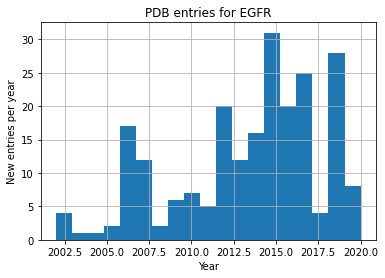

In [10]:
# Extract year
years = pdbs["deposition_date"].apply(lambda x: x.year)
bins = years.max() - years.min() + 1
axes = years.hist(bins=bins)
axes.set_ylabel("New entries per year")
axes.set_xlabel("Year")
axes.set_title("PDB entries for EGFR");

### Filter and sort meta information on PDB entries

We start filtering our dataset based on the following criteria:

#### Year cutoff

This step is for TeachOpenCADD-internal maintanence purposes: We will only consider structures that were deposited before 2020. That way the results of this notebooks will stay the same over time, allowing us to check with our continuous integration (CI) that this notebook does not go out of service.

In [11]:
pdbs = pdbs[pdbs["deposition_date"] < "2020-01-01"]
print(f"Number of PDB structures deposited before 2020: {len(pdbs)}")

Number of PDB structures deposited before 2020: 213


#### Experimental method: X-ray diffraction

We only keep structures resolved by `X-RAY DIFFRACTION`, the most commonly used structure determination method. 

In [12]:
pdbs = pdbs[pdbs["experimental_method"] == "X-RAY DIFFRACTION"]
print(f"Number of PDB structures for EGFR from X-ray: {len(pdbs)}")

Number of PDB structures for EGFR from X-ray: 207


#### Structural resolution

We only keep structures with a resolution equal or lower than 3 Å. The lower the resolution value, the higher is the quality of the structure (-> the higher is the certainty that the assigned 3D coordinates of the atoms are correct). Below 3 Å, atomic orientations can be determined  and therefore is often used as threshold for structures relevant for structure-based drug design.

In [13]:
pdbs = pdbs[pdbs["resolution"] <= 3.0]
print(f"Number of PDB entries for EGFR from X-ray with resolution <= 3.0 Angstrom: {len(pdbs)}")

Number of PDB entries for EGFR from X-ray with resolution <= 3.0 Angstrom: 172


We sort the data set by the structural resolution. 

In [14]:
pdbs = pdbs.sort_values(["resolution"], ascending=True, na_position="last")

We check the top PDB structures (sorted by resolution): 

In [15]:
pdbs.head()[["pdb_id", "resolution"]]

,pdb_id,resolution
217,5UG9,1.33
220,5HG8,1.42
216,5UG8,1.46
166,6TG0,1.50
165,6TFV,1.50


#### Ligand-bound structures

Since we will create ensemble ligand-based pharmacophores in the next talktorial, we remove all PDB structures from our DataFrame, which do not contain a bound ligand: we use the `pypdb` function `get_ligands` to check/retrieve the ligand(s) from a PDB structure. PDB-annotated ligands can be ligands, cofactors, but also solvents and ions. In order to filter only ligand-bound structures, we (i) remove all structures without any annotated ligand and (ii) remove all structures that do not contain any ligands with a molecular weight (MW) greater than 100 Da (Dalton), since many solvents and ions weight less. Note: this is a simple, but not comprehensive exclusion of solvents and ions. 

In [ ]:
# Get all PDB IDs from DataFrame
pdb_ids = pdbs["pdb_id"].tolist()

In [ ]:
# Remove structures
# (i) without ligand and
# (ii) without any ligands with molecular weight (MW) greater than 100 Da (Dalton)


@redo.retriable(attempts=10, sleeptime=2)
def get_ligands(pdb_id):
    """Decorate pypdb.get_ligands so it retries after a failure."""
    return pypdb.get_ligands(pdb_id)


mw_cutoff = 100.0  # Molecular weight cutoff in Da

# This database query may take a moment
passed_pdb_ids = []
removed_pdb_ids = []
progressbar = tqdm(pdb_ids)
for pdb_id in progressbar:
    progressbar.set_description(f"Processing {pdb_id}...")
    ligand_dict = get_ligands(pdb_id)

    # (i) Remove structure if no ligand present
    if ligand_dict["ligandInfo"] is None:
        removed_pdb_ids.append(pdb_id)  # Store ligand-free PDB IDs

    # (ii) Remove structure if not a single annotated ligand has a MW above mw_cutoff
    else:
        # Get ligand information
        ligands = ligand_dict["ligandInfo"]["ligand"]
        # Technicality: if only one ligand, cast dict to list (for the subsequent list comprehension)
        if type(ligands) == dict:
            ligands = [ligands]
        # Get MW per annotated ligand
        mw_list = [float(ligand["@molecularWeight"]) for ligand in ligands]
        # Remove structure if not a single annotated ligand has a MW above mw_cutoff
        if sum([mw > mw_cutoff for mw in mw_list]) == 0:
            removed_pdb_ids.append(pdb_id)  # Store ligand-free PDB IDs
        else:
            passed_pdb_ids.append(pdb_id)  # Remove ligand-free PDB IDs from list

In [ ]:
print(
    "PDB structures without a ligand (removed from our data set):",
    *removed_pdb_ids,
)
print("Number of structures with ligand:", len(passed_pdb_ids))

### Get meta information of ligands from top structures

In the next talktorial, we will build ligand-based ensemble pharmacophores from the top `top_num` structures with the highest resolution.

In [ ]:
top_num = 8  # Number of top structures
selected_pdb_ids = passed_pdb_ids[:top_num]
selected_pdb_ids

The selected highest resolution PDB entries can contain ligands targeting different binding sites, e.g. allosteric and orthosteric ligands, which would hamper ligand-based pharmacophore generation. Thus, we will focus on the following 4 structures, which contain ligands in the orthosteric binding pocket. The code provided later in the notebook can be used to verify this.

In [ ]:
selected_pdb_ids = ["5UG9", "5HG8", "5UG8", "3POZ"]

We fetch the PDB information about the top `top_num` ligands using `get_ligands`, to be stored as *csv* file (as dictionary per ligand).

If a structure contains several ligands, we select the largest ligand. Note: this is a simple, but not comprehensive method to select ligand binding the binding site of a protein. This approach may also select a cofactor bound to the protein. Therefore, please check the automatically selected top ligands visually before further usage.

In [ ]:
ligands_list = []

for pdb_id in selected_pdb_ids:
    ligands = get_ligands(pdb_id)["ligandInfo"]["ligand"]

    # Technicality: if only one ligand, cast dict to list (for the subsequent list comprehension)
    if isinstance(ligands, dict):
        ligands = [ligands]

    weight = 0
    this_lig = {}

    # If several ligands contained, take largest
    for ligand in ligands:
        if float(ligand["@molecularWeight"]) > weight:
            this_ligand = ligand
            weight = float(ligand["@molecularWeight"])

    ligands_list.append(this_ligand)

In [ ]:
# NBVAL_CHECK_OUTPUT
# Change the format to DataFrame
ligands = pd.DataFrame(ligands_list)
ligands

In [ ]:
ligands.to_csv(DATA / "PDB_top_ligands.csv", header=True, index=False)

### Draw top ligand molecules

In [ ]:
PandasTools.AddMoleculeColumnToFrame(ligands, "smiles")
Draw.MolsToGridImage(
    mols=list(ligands.ROMol),
    legends=list(ligands["@chemicalID"] + ", " + ligands["@structureId"]),
    molsPerRow=top_num,
)

### Create protein-ligand ID pairs

In [ ]:
# NBVAL_CHECK_OUTPUT
pairs = collections.OrderedDict(zip(ligands["@structureId"], ligands["@chemicalID"]))
pairs

### Align PDB structures

Since we want to build ligand-based ensemble pharmacophores in the next talktorial, it is necessary to align all structures to each other in 3D. 

We will use one the python package `opencadd` ([repository](https://github.com/volkamerlab/opencadd)), which includes a 3D superposition subpackage  to guide the structural alignment of the proteins. The approach is based on superposition guided by sequence alignment provided matched residues. There are other methods in the package, but this simple one will be enough for the task at hand.

#### Get the PDB structure files

We now fetch the PDB structure files, i.e. 3D coordinates of the protein, ligand (and if available other atomic or molecular entities such as cofactors, water molecules, and ions) from the PDB using `opencadd.structure.superposition`. 

Available file formats are *pdb* and *cif*, which store the 3D coordinations of atoms of the protein (and ligand, cofactors, water molecules, and ions) as well as information on bonds between atoms. Here, we work with *pdb* files.

In [ ]:
# Download PDB structures
structures = [Structure.from_pdbid(pdb_id) for pdb_id in pairs]
structures

#### Extract protein and ligand

Extract protein and ligand from the structure in order to remove solvent and other artifacts of crystallography.

In [ ]:
complexes = [
    Structure.from_atomgroup(structure.select_atoms(f"protein or resname {ligand}"))
    for structure, ligand in zip(structures, pairs.values())
]
complexes

In [ ]:
# Write complex to file
for complex_, pdb_id in zip(complexes, pairs.keys()):
    complex_.write(DATA / f"{pdb_id}.pdb")

#### Align proteins

Align complexes (based on protein atoms).

In [ ]:
results = align(complexes, method=METHODS["mda"])

`nglview` can be used to visualize molecular data within Jupyter notebooks. With the next cell we will visualize out aligned protein-ligand complexes.

In [ ]:
view = nglview.NGLWidget()
for complex_ in complexes:
    view.add_component(complex_.atoms)
view

In [ ]:
view.render_image(trim=True, factor=2, transparent=True);

In [ ]:
view._display_image()

#### Extract ligands 

In [ ]:
ligands = [
    Structure.from_atomgroup(complex_.select_atoms(f"resname {ligand}"))
    for complex_, ligand in zip(complexes, pairs.values())
]
ligands

In [ ]:
for ligand, pdb_id in zip(ligands, pairs.keys()):
    ligand.write(DATA / f"{pdb_id}_lig.pdb")

We check the existence of all ligand *pdb* files.

In [ ]:
ligand_files = []
for file in DATA.glob("*_lig.pdb"):
    ligand_files.append(file.name)
ligand_files

We can also use `nglview` to depict the co-crystallized ligands alone. As we can see, the selected complexes contain ligands populating the same binding pocket and can thus be used in the next talktorial for ligand-based pharmacophore generation.

In [ ]:
view = nglview.NGLWidget()
for component_id, ligand in enumerate(ligands):
    view.add_component(ligand.atoms)
    view.remove_ball_and_stick(component=component_id)
    view.add_licorice(component=component_id)
view

In [ ]:
view.render_image(trim=True, factor=2, transparent=True);

In [ ]:
view._display_image()

## Discussion

In this talktorial, we learned how to retrieve protein and ligand meta information and structural information from the PDB. We retained only X-ray structures and filtered our data by resolution and ligand availability. Ultimately, we aimed for an aligned set of ligands to be used in the next talktorial for the generation of ligand-based ensemble pharmacophores. 

In order to enrich information about ligands for pharmacophore modeling, it is advisable to not only filter by PDB structure resolution, but also to check for ligand diversity (see **Talktorial 005** on molecule clustering by similarity) and to check for ligand activity (i.e. to include only potent ligands). 

## Quiz

1. Summarize the kind of data that the Protein Data Bank contains.
2. Explain what the resolution of a structure stands for and how and why we filter for it in this talktorial.
3. Explain what an alignment of structures means and discuss the alignment performed in this talktorial.